In [1]:
# Add the root to sys.path so Python can find the src folder
import sys
import os
sys.path.append(os.path.abspath(".."))

from src import load_csv

# Load the Benin dataset
df_togo = load_csv('togo-dapaong_qc.csv')
df_togo.head()


Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [2]:
from src import get_date_range
import pandas as pd
# Call your function
start, end = get_date_range(df_togo)

# Print result
print(f"Benin data range: {start} to {end}")

Benin data range: 2021-10-25 to 2022-10-25


#### loading
>as we already initalize load in 'src/__init__.py' first we call and load a file

In [3]:
from src import   missing_value_report
# Missing data
missing = missing_value_report(df_togo)
print(missing["missing_counts"])
print("Columns with >5% nulls:", missing["high_null_columns"])

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64
Columns with >5% nulls: ['Comments']


### Missing Value
we can see that there is no missing column **except comment column** which is empty column so better to drop it 

In [4]:
# Drop 'Comments' column if all values are NaN or it's just empty
if 'Comments' in df_togo.columns and df_togo['Comments'].isna().all():
    df_togo.drop(columns='Comments', inplace=True)


In [5]:
from src import summary_statistics

# Summary stats
print(summary_statistics(df_togo))

                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000      24.200000   
50%         2.500000    

#### explanation of the above statstics
it is shown that GHI            DNI           and DHI have a -ve value which is unacceptable as the minimum value is 0

In [6]:
irradiance_cols = ['GHI', 'DNI', 'DHI']
neg_counts = (df_togo[irradiance_cols] < 0).sum()
print("Ivalid Negative value counts\n", neg_counts)

Ivalid Negative value counts
 GHI    257385
DNI         0
DHI         0
dtype: int64


C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\3992174399.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_togo[['GHI', 'DNI', 'DHI']].resample('H').mean()


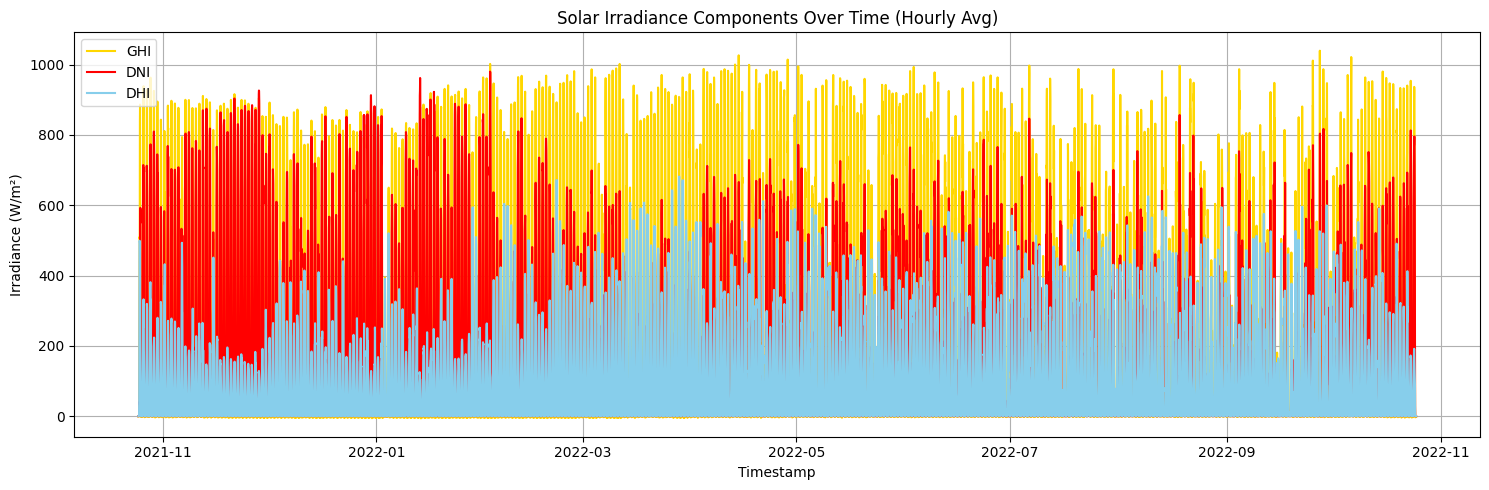

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


df_togo['Timestamp'] = pd.to_datetime(df_togo['Timestamp'])
df_togo.set_index('Timestamp', inplace=True)

# Optional: Resample to hourly average to reduce noise
df_hourly = df_togo[['GHI', 'DNI', 'DHI']].resample('H').mean()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly['GHI'], label='GHI', color='gold')
plt.plot(df_hourly.index, df_hourly['DNI'], label='DNI', color='red')
plt.plot(df_hourly.index, df_hourly['DHI'], label='DHI', color='skyblue')

plt.title('Solar Irradiance Components Over Time (Hourly Avg)')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Negative Irradiance Values Summary

| **Feature** | **# of Negative Values** | **% of Total Rows** |
|-------------|---------------------------|----------------------|
| **GHI**     | 257,385                   | ~49%               |


---

###  Interpretation

Negative values in irradiance data can be caused by:

-  **Nighttime readings**, when solar radiation should naturally be **0**, not negative.
-  **Sensor bias or drift**, where instruments slightly **dip below zero** due to low signal or calibration issues — especially at night.

While this behavior is **not abnormal in raw solar data**, negative irradiance values should be **Cleaned before analysis** or modeling So we do further analysis to know why it happens and by what to replace or clip.
This ensures physical accuracy and avoids misleading statistical summaries or visualizations.


C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\2604843053.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_togo[[col]].resample('H').mean()


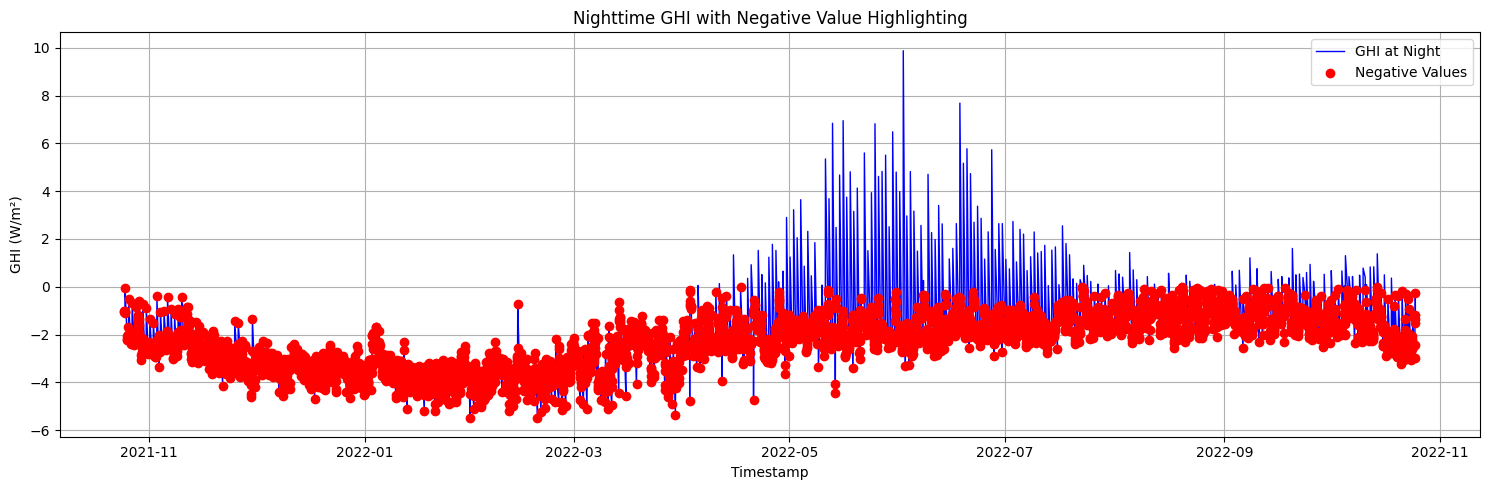

C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\2604843053.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_togo[[col]].resample('H').mean()


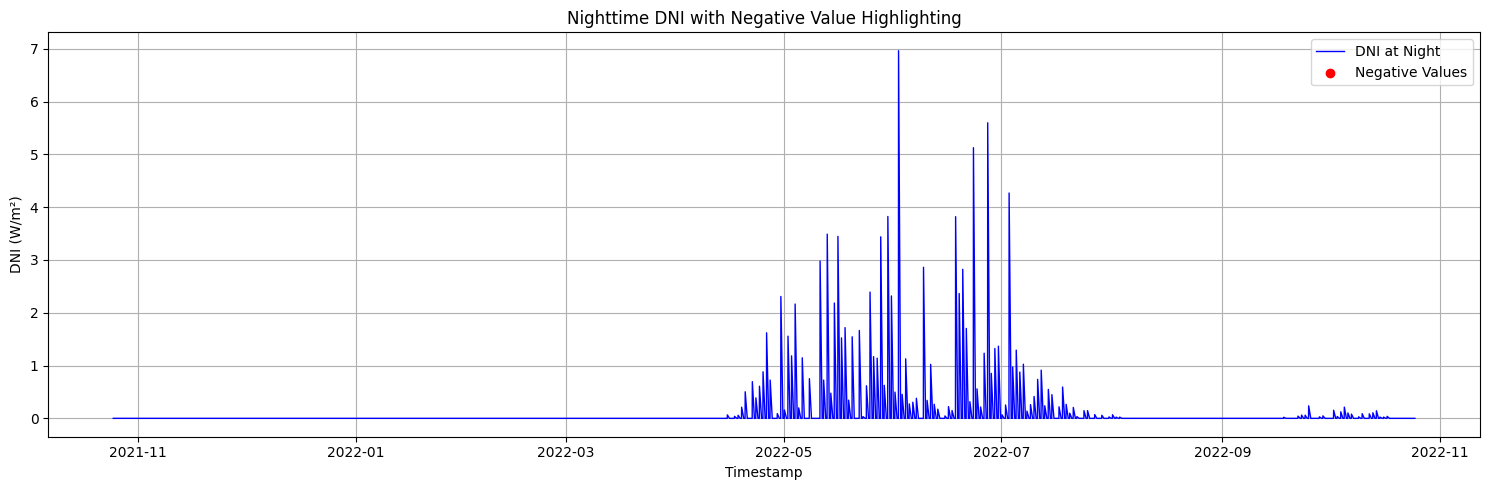

C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\2604843053.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_togo[[col]].resample('H').mean()


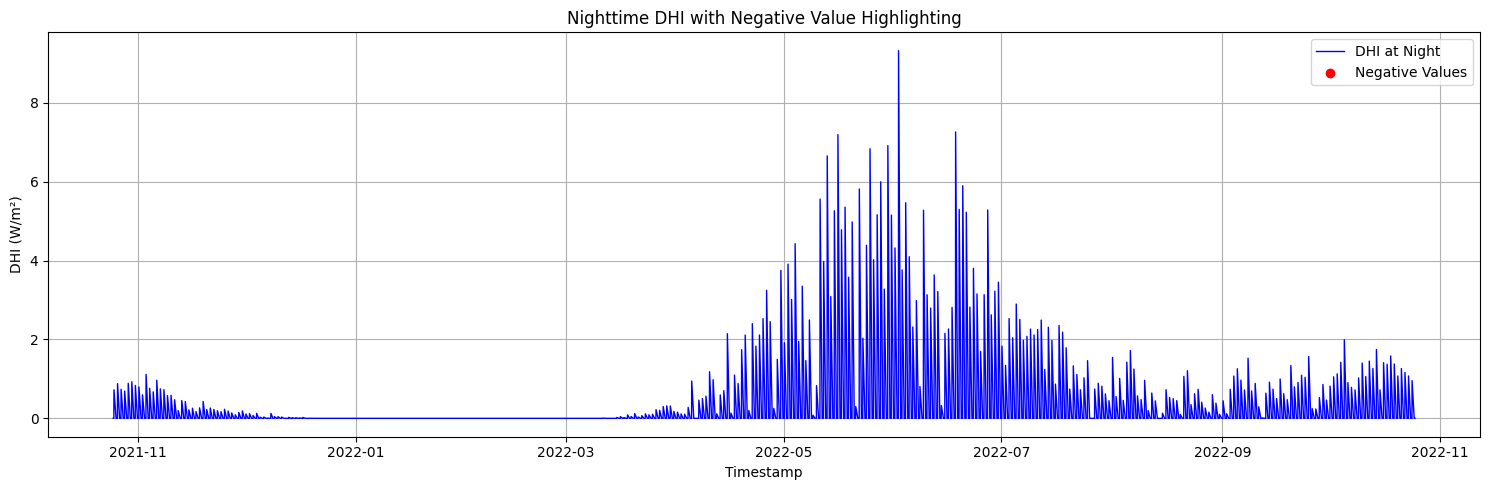

In [8]:
import pandas as pd
import matplotlib.pyplot as plt



# Loop through each irradiance component
for col in irradiance_cols:
    # Resample to hourly average
    df_hourly = df_togo[[col]].resample('H').mean()

    # Define hour and classify nighttime
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['is_night'] = ~df_hourly['hour'].between(6, 18)  # Night is before 6AM or after 6PM
    df_hourly['is_negative'] = df_hourly[col] < 0

    # Filter for nighttime data
    df_night = df_hourly[df_hourly['is_night']]

    # Plot irradiance during nighttime
    plt.figure(figsize=(15, 5))
    plt.plot(df_night.index, df_night[col], label=f'{col} at Night', color='blue', linewidth=1)

    # Highlight negative irradiance values
    negative_values = df_night[df_night['is_negative']]
    plt.scatter(negative_values.index, negative_values[col], color='red', label='Negative Values', zorder=3)

    # Add labels and show plot
    plt.title(f'Nighttime {col} with Negative Value Highlighting')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{col} (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\1726784897.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_togo[['GHI']].resample('H').mean()


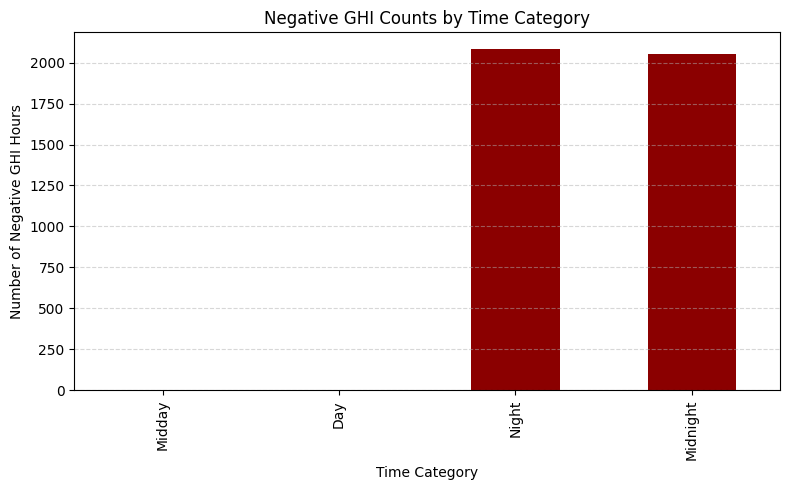

In [9]:


# Resample to hourly averages for GHI
df_hourly = df_togo[['GHI']].resample('H').mean()
df_hourly['hour'] = df_hourly.index.hour

# Classify time into 4 categories
def classify_period(hour):
    if 11 <= hour <= 13:
        return 'Midday'
    elif 6 <= hour <= 10:
        return 'Day'
    elif 0 <= hour <= 5:
        return 'Midnight'
    else:
        return 'Night'

df_hourly['time_category'] = df_hourly['hour'].apply(classify_period)
df_hourly['is_negative'] = df_hourly['GHI'] < 0

# Filter only negative GHI
negative_ghi = df_hourly[df_hourly['is_negative']]

# Count how many negative values fall into each time category
neg_ghi_counts = negative_ghi['time_category'].value_counts().reindex(['Midday', 'Day', 'Night', 'Midnight'], fill_value=0)

# Plot bar chart
plt.figure(figsize=(8, 5))
neg_ghi_counts.plot(kind='bar', color='darkred')
plt.title('Negative GHI Counts by Time Category')
plt.xlabel('Time Category')
plt.ylabel('Number of Negative GHI Hours')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🌙 Nighttime Irradiance Values and Data Cleaning

It is clearly shown that the **negative values in GHI** correspond to the **nighttime period**—when the sun is no longer visible and solar radiation should, by physics, be zero.

 Why This Happens
These negative values are not physically meaningful; they likely result from:
- **Sensor bias or drift** at night
- **Baseline miscalibration** of the equipment
- **Electronic noise** during low-light conditions

Since solar irradiance is **energy from sunlight**, it should never be negative. Even on cloudy days, irradiance may be low, but not below zero. At night, it should naturally be **zero**.


As a result, **all negative values in GHI was safely replaced with 0**, aligning with real-world solar physics and making the dataset more reliable for analysis and modeling.

 Why This Matters
Cleaning these values:
- Improves the accuracy of statistical summaries
- Prevents skewing machine learning models in later phases
- Helps identify real solar potential without artificial noise



In [10]:
# Replace all invalid negatives with 0
df_togo[irradiance_cols] = df_togo[irradiance_cols].clip(lower=0)


make all -ve value of **irradiance_cols** to **0** for better analysis by using .clip(replace all values with lower 0 with 0 )

In [11]:
import matplotlib.pyplot as plt

# Function to detect and plot time-series trends with optional smoothing
def plot_trend(df_togo, column, window=24, title_suffix='Trend Over Time'):
    """
    Plots a time-series line chart of a column with optional rolling average.

    Args:
        df (pd.DataFrame): DataFrame with datetime index.
        column (str): Column name to plot.
        window (int): Smoothing window (e.g. 24 = 1 day if hourly data).
        title_suffix (str): Title customization.

    Returns:
        None
    """
    if column not in df_togo.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")

    plt.figure(figsize=(15, 5))

    # Raw data line
    plt.plot(df_togo.index, df_togo[column], color='lightgray', alpha=0.5, label='Raw')

    # Smoothed trend line
    smoothed = df_togo[column].rolling(window=window, min_periods=1).mean()
    plt.plot(df_togo.index, smoothed, color='crimson', linewidth=2, label=f'{column} ({window}-pt avg)')

    plt.title(f'{column} {title_suffix}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


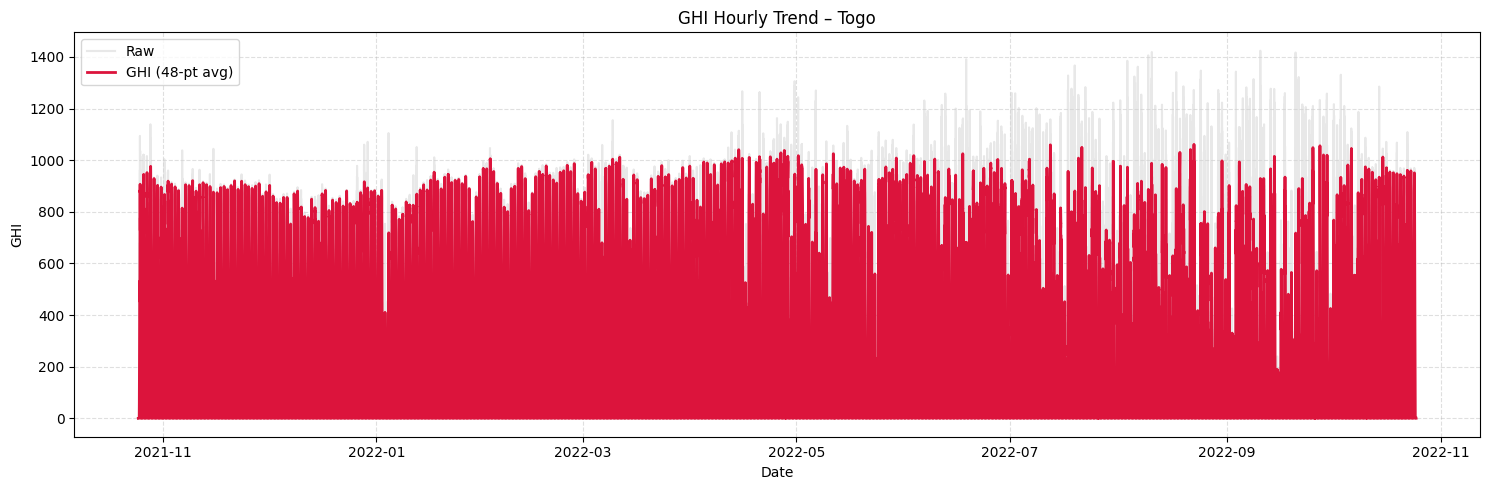

C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\1572098200.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\ABC\Desktop\10Acadamy\solar_analysis_code\solar-site-analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


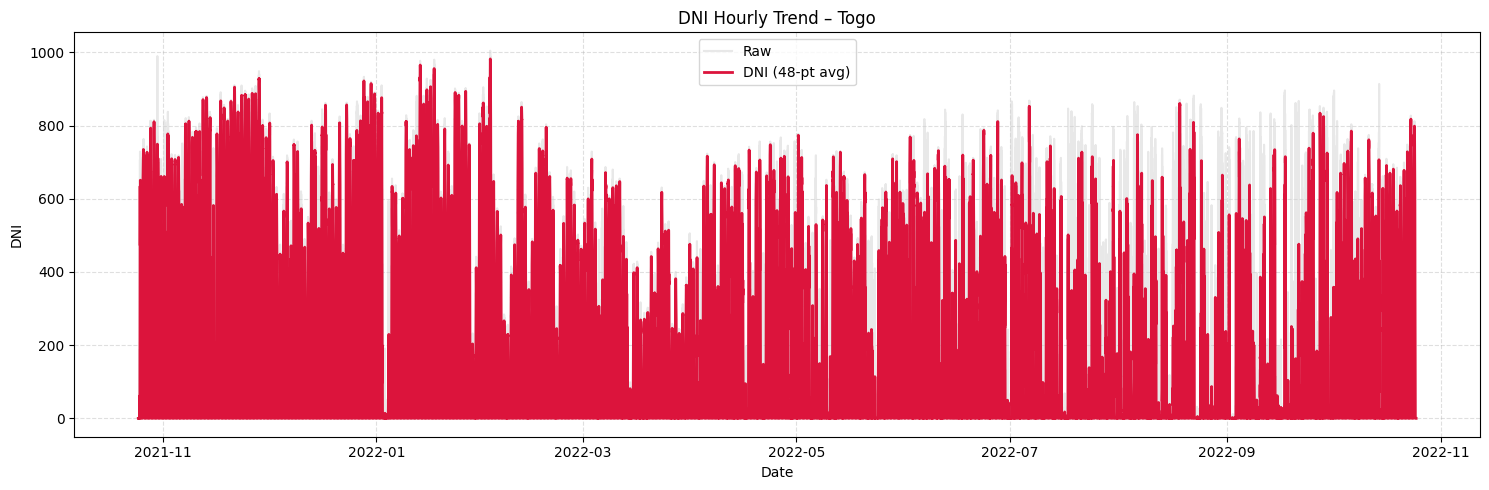

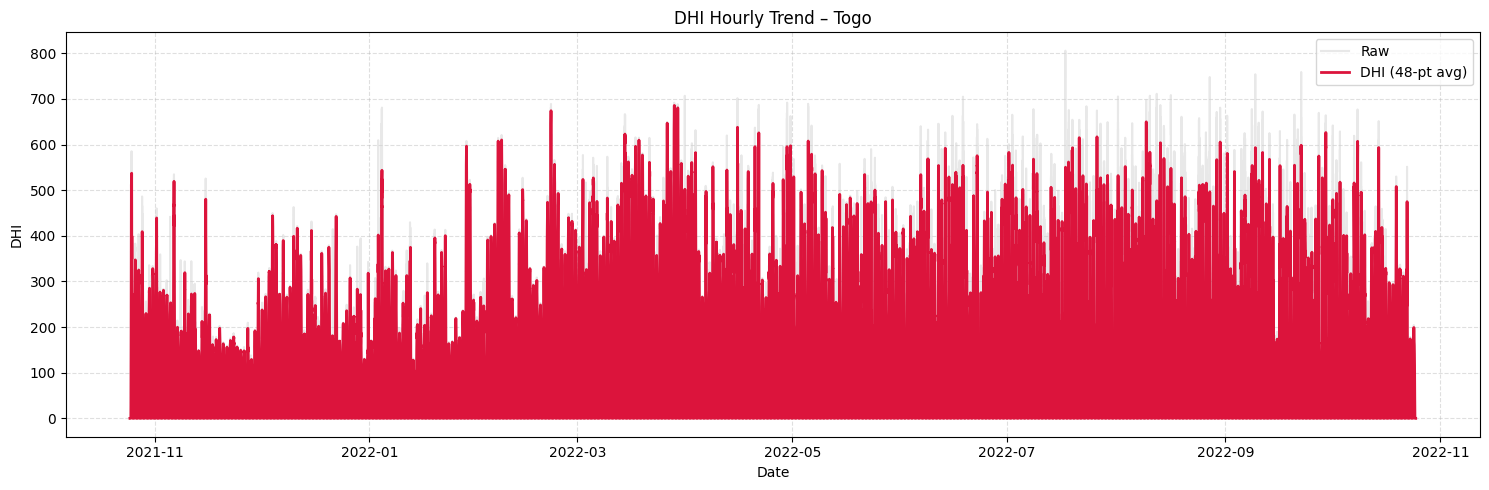

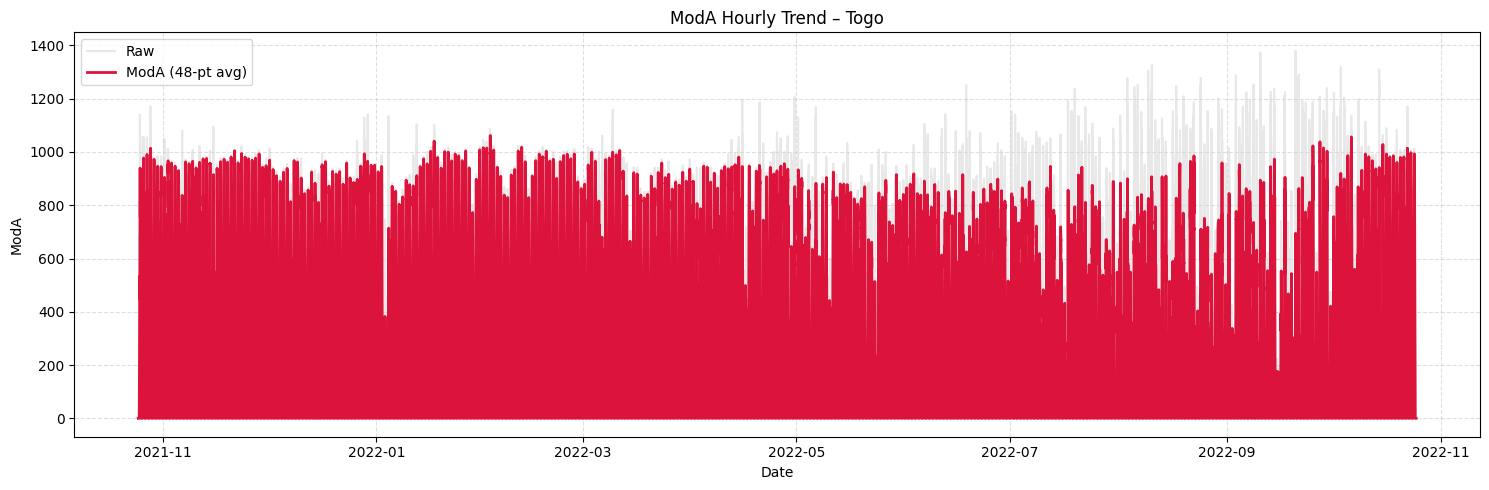

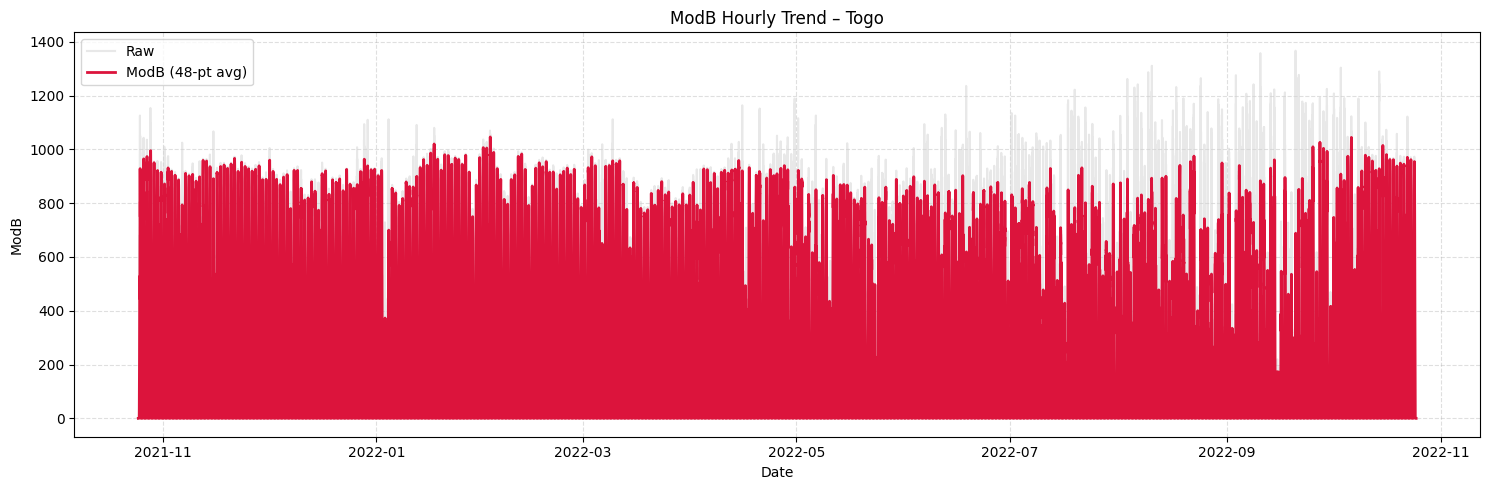

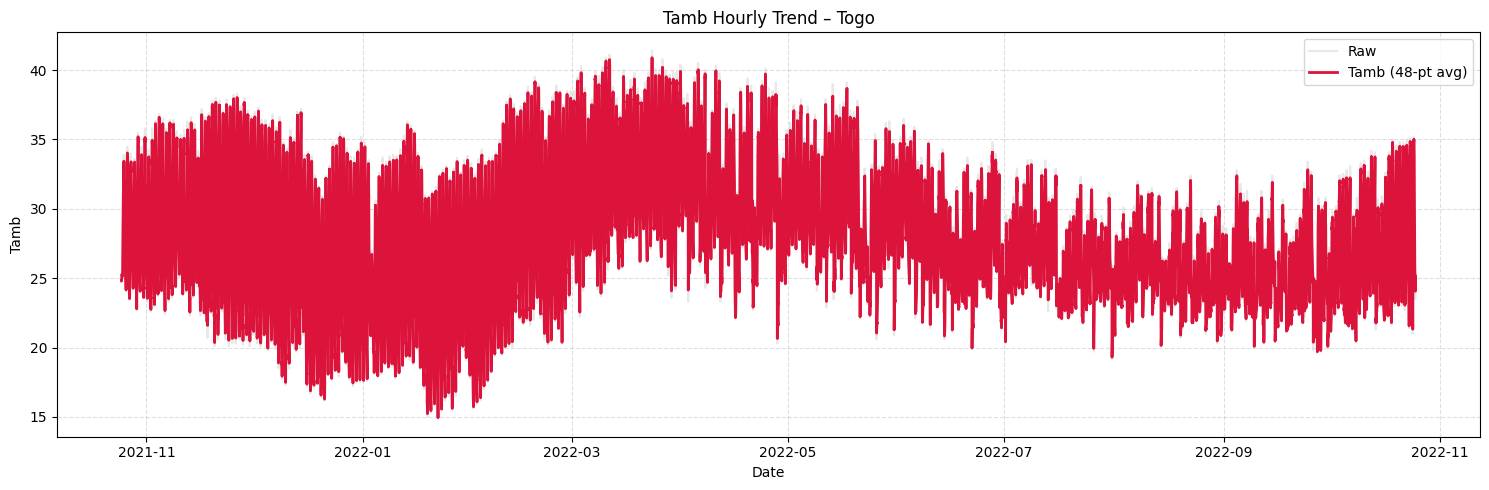

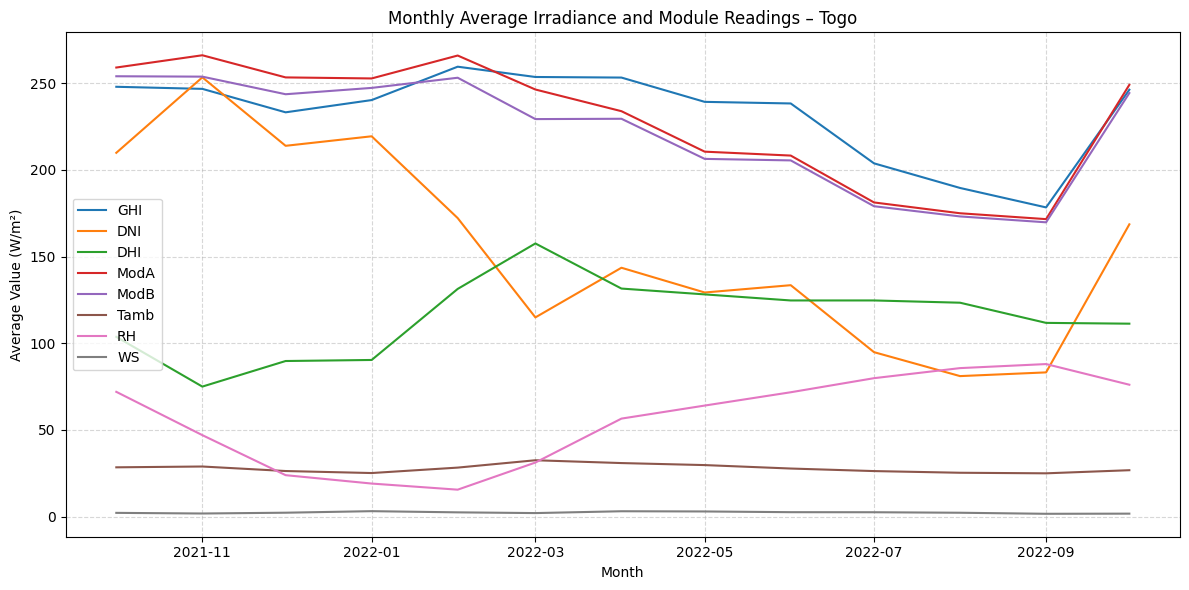

In [12]:
# Ensure df_benin has datetime index
plot_trend(df_togo, 'GHI', window=48, title_suffix='Hourly Trend – Togo')
plot_trend(df_togo, 'DNI', window=48, title_suffix='Hourly Trend – Togo')
plot_trend(df_togo, 'DHI', window=48, title_suffix='Hourly Trend – Togo')
plot_trend(df_togo, 'ModA', window=48, title_suffix='Hourly Trend – Togo')
plot_trend(df_togo, 'ModB', window=48, title_suffix='Hourly Trend – Togo')
plot_trend(df_togo,'Tamb', window=48, title_suffix='Hourly Trend – Togo')

# Create a new column 'Month' from the datetime index
df_togo['Month'] = df_togo.index.to_period('M')


# Group by month and compute average of key variables
monthly_avg = df_togo.groupby('Month')[['GHI', 'DNI', 'DHI', 'ModA', 'ModB','Tamb','RH', 'WS']].mean()

# Plot the monthly average trends
plt.figure(figsize=(12, 6))
for col in monthly_avg.columns:
    plt.plot(monthly_avg.index.to_timestamp(), monthly_avg[col], label=col)

plt.title('Monthly Average Irradiance and Module Readings – Togo')
plt.xlabel('Month')
plt.ylabel('Average Value (W/m²)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## ✅ Overall Seasonal Alignment

- **Dry Season (Nov–Apr):** Clear skies → high DNI, lower DHI, warmer module temps  
- **Wet Season (May–Oct):** Cloud cover and humidity rise → lower DNI, higher DHI, cooler or fluctuating module temps  

---

## 🔎 Breakdown of Each Interval You Mentioned

### 🔸 Oct → Nov  
**“DNI, ModA rise a little; GHI & ModB stable; RH & DHI drop”**

✔️ **Makes sense:**
- Transitioning from wet to dry season → clouds clear, direct sunlight (DNI) increases.
- Less diffuse light (DHI drops) because the sun becomes more direct.
- ModA (maybe more exposed panel) heats up slightly from clearer skies.

---

### 🔸 Nov → Dec  
**“DNI drops; GHI, ModA/ModB drop slightly; DHI rises”**

✔️ **Consistent with Harmattan:**
- December is the peak of Harmattan winds – dry but dusty, which scatters sunlight:
  - DNI drops due to atmospheric particles blocking direct beam.
  - DHI rises due to light scattering (even though skies may seem “clear”).
- Temperature may dip slightly due to seasonal dry winds = slight drop in module temps.

---

### 🔸 Dec → Jan  
**“All around stable”**

✔️ **As expected:**
- Deep in the dry season.
- Climate is relatively stable, with consistent clear skies and low rainfall.

---

### 🔸 Jan → Mar  
**“DNI decreases, DHI increases, GHI increases slightly, ModA/B decrease”**

✔️ **Yes – logical seasonal transition:**
- More moisture returns gradually, especially in March.
- Thin clouds or haze increase DHI, reduce DNI, but GHI stays stable (because diffuse + direct still sums up).
- Slight drop in Mod temps may be due to increased cloud cover or early rains reducing ambient heat.

---

### 🔸 Apr → May  
**“GHI, ModA/B decrease; DHI constant; DNI drops”**

✔️ **Accurate transition to wet season:**
- May begins wet season → more overcast → DNI drops further.
- GHI and module temps drop due to less sun + more cloud cover.
- DHI remains constant – typical for early wet season: light is still scattered but not fully cloud-blocked.

---

### 🔸 Jun → Sep  
**“GHI drops; RH slightly increases; DHI slightly decreases; DNI decreases”**

✔️ **Fully matches the peak wet season:**
- High RH (humidity) and persistent clouds block both direct and some diffuse sunlight.
- DNI drops most due to thick cloud cover.
- DHI may even decline because thick clouds also reduce sky brightness.
- GHI drops significantly (reduced solar energy potential here).

---

### 🔸 Sep → Nov  
**“High increase of DHI, ModA/B when DNI increases”**

✔️ **Logical pattern as clouds start clearing:**
- Sun returns, so DNI increases.
- DHI can spike during partly cloudy days (scattered cloud edges brighten sky even more).
- Module temps rise again from increased total irradiance (GHI = DNI + DHI).


In [13]:
from scipy.stats import zscore
import numpy as np

df_togo.reset_index(inplace=True)
# Convert timestamp column to datetime if exists
if 'Timestamp' in df_togo.columns:
    df_togo['Timestamp'] = pd.to_datetime(df_togo['Timestamp'], errors='coerce')
else:
    df_togo.index = pd.to_datetime(df_togo.index, errors='coerce')


# Create a 'month' column for seasonal grouping
df_togo['month'] = df_togo['Timestamp'].dt.month

# Columns to check
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores per column
z_scores = df_togo[cols_to_check].apply(zscore)

# Step 2: Mask where Z-scores are beyond the threshold
z_outlier_mask = np.abs(z_scores) > 3

# Step 3: Flag rows with any outlier
rows_with_outliers = z_outlier_mask.any(axis=1)
# Assuming original df_togo has 'TIMESTAMP' column
outlier_info = df_togo.loc[rows_with_outliers, ['Timestamp'] + cols_to_check].copy()

# Add outlier columns flag
outlier_info['z_outlier_cols'] = z_outlier_mask[rows_with_outliers].apply(
    lambda row: ', '.join(row[row].index.tolist()), axis=1
)



---
### Z-Score > 3 Outlier Analysis

The **Z-score** is a statistical measure that tells us how far a data point is from the mean in terms of standard deviations. It is calculated as:

> **Z = (value − mean) / standard deviation**

A **Z-score > 3 or < -3** typically means the value is an extreme outlier (i.e., it's more than 3 standard deviations away from the average). This helps us identify rare, abnormal readings in our solar measurements — such as sensor malfunctions, sudden environmental changes, or peak sunlight events.

---

In [14]:
# Your local path to save the file
save_path = r"C:\Users\ABC\Desktop\10Acadamy\solar_analysis_code\solar-site-analysis\data\z_outlier_flags_togo.csv"

# Save the DataFrame with outliers
outlier_info.to_csv(save_path)

print(f"Outliers successfully saved at {save_path}")


Outliers successfully saved at C:\Users\ABC\Desktop\10Acadamy\solar_analysis_code\solar-site-analysis\data\z_outlier_flags_togo.csv


In [15]:
import pandas as pd

# First, load without parsing dates
df_togo_outliner = pd.read_csv(r"C:\Users\ABC\Desktop\10Acadamy\solar_analysis_code\solar-site-analysis\data\z_outlier_flags_togo.csv")

# See what the actual column names are
print(df_togo_outliner.columns)


Index(['Unnamed: 0', 'Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS',
       'WSgust', 'z_outlier_cols'],
      dtype='object')


In [16]:
import pandas as pd
from collections import defaultdict

# Load your CSV file
df_outlier = pd.read_csv(r"C:/Users/ABC/Desktop/10Acadamy/solar_analysis_code/solar-site-analysis/data/z_outlier_flags_togo.csv", parse_dates=['Timestamp'])

# Extract hour from timestamp
df_outlier['Hour'] = df_outlier['Timestamp'].dt.hour

# Define time intervals
time_intervals = {
    "Midday (11AM - 1PM)": range(11, 14),
    "Midnight (11PM - 1AM)": [23, 0, 1],
    "After Midday (1PM - 11PM)": range(14, 23),
    "After Midnight (1AM - 11AM)": range(2, 11)
}

# Initialize results storage
results = defaultdict(lambda: defaultdict(int))

# Iterate over each row to count outliers per column per interval
for _, row in df_outlier.iterrows():
    cols = row['z_outlier_cols'].split(', ')
    hour = row['Hour']

    # Determine the time interval (corrected keys)
    if hour in time_intervals["Midday (11AM - 1PM)"]:
        interval = "Midday (11AM - 1PM)"
    elif hour in time_intervals["Midnight (11PM - 1AM)"]:
        interval = "Midnight (11PM - 1AM)"
    elif hour in time_intervals["After Midnight (1AM - 11AM)"]:
        interval = "After Midnight (1AM - 11AM)"
    elif hour in time_intervals["After Midday (1PM - 11PM)"]:
        interval = "After Midday (1PM - 11PM)"
    else:
        interval = "Other Times"

    # Increment counts for each column flagged as outlier
    for col in cols:
        results[col][interval] += 1

# Convert results into a DataFrame for clearer interpretation
time_analysis_df = pd.DataFrame(results).fillna(0).astype(int).T

print("\n🌞 Outlier Counts by Time of Day for Each Column 🌜")
print(time_analysis_df)



🌞 Outlier Counts by Time of Day for Each Column 🌜
        Midday (11AM - 1PM)  After Midnight (1AM - 11AM)  \
ModB                    181                           24   
WSgust                  573                         1679   
WS                      555                         1504   
DNI                     773                          237   
DHI                    2797                          596   
GHI                     268                           43   
ModA                    119                           17   

        After Midday (1PM - 11PM)  Midnight (11PM - 1AM)  
ModB                            1                      0  
WSgust                       1232                    431  
WS                           1091                    360  
DNI                            52                      0  
DHI                            22                      0  
GHI                             3                      0  
ModA                            1                      



## 📊 Interpretation of Each Column by Time Slot

### ⏰ Time Slots Used:
- **Midday (11AM–1PM)** = Peak solar period  
- **After Midnight (1AM–11AM)** = Mostly dark  
- **After Midday (1PM–11PM)** = Sunset and night  
- **Midnight (11PM–1AM)** = Full night  

---

### 🌞 GHI (Global Horizontal Irradiance)

- **Midday: 268**  
  → Expected: GHI peaks, but high outliers may suggest **sensor overreadings** or **clear-sky anomalies**.  
- **Night hours (1AM–11AM & 11PM–1AM): 43 and 0**  
  → ✅ Good. Night GHI should be 0; low outlier count suggests **clean data**.  
- **After Midday: Only 3**  
  → Again, a good sign. Sunset values fade normally.

✔️ **Conclusion**:  
GHI data is mostly clean. Midday outliers may be real (clear sky surges) or sensor clipping.

---

### 🔆 DNI (Direct Normal Irradiance)

- **Midday: 773 (⚠️ high)**  
  → Strong outliers during peak sun indicate **sensor spikes** or **rapid cloud changes**.  
- **1AM–11AM: 237**  
  → ❌ Unnatural. DNI should be 0 at night.and hitting the outlier before 11AM is unusal. This hints at **sensor noise** or **improper zeroing**.  
- **1PM–11PM: Only 52**  
  → Good.

✔️ **Conclusion**:  
Nighttime DNI outliers are problematic. Likely **instrument drift**. Midday spikes are expected but worth verifying with clear-sky models.

---

### 🌤️ DHI (Diffuse Horizontal Irradiance)

- **Midday: 2797 (!!)**  
  → ⚠️ Extremely high outlier count. This suggests **over-sensitive sensors** or **cloud-edge enhancement**.  
- **1AM–11AM: 596**  
  → ❌ High for nighttime.  
- **Other times: Low**  
  → Acceptable.

✔️ **Conclusion**:  
DHI has **major noise** or **miscalibrated sensor readings**, especially if outliers occur when it should be near-zero (nighttime).

---

### 🌡️ ModA / ModB (Module Temperatures)

- **ModB: Midday = 181**, **1AM–11AM = 24** → ✔️ Reasonable  
- **ModA: Midday = 119**, **1AM–11AM = 17** → ✔️ Also reasonable

These outliers could reflect **true heat spikes**, or **unusual cooling patterns** (e.g., sudden cloud or rain), or **sensor errors**.

✔️ **Conclusion**:  
ModA/B outliers are generally acceptable in small numbers. Most likely reflect **real panel heat/cooling swings**.

---

### 💨 WS / WSgust (Wind Speed + Gust)

- **WSgust**  
  - Midday: 573  
  - After Midnight: 1679  
  - After Midday: 1232  
  - Midnight: 431  
  → ⚠️ High gust outliers, especially at night. Possibly:
    - Real windy events (e.g., storms), or  
    - **Sensitive gust sensors** triggering on small air bursts.

- **WS (average wind)**  
  → Similar pattern: Nighttime wind outliers seem high for a tropical region **unless local wind bursts or storms are common**.

✔️ **Conclusion**:  
Wind sensors might be **over-triggering at night**. Worth flagging for **sensor QC or calibration review**.





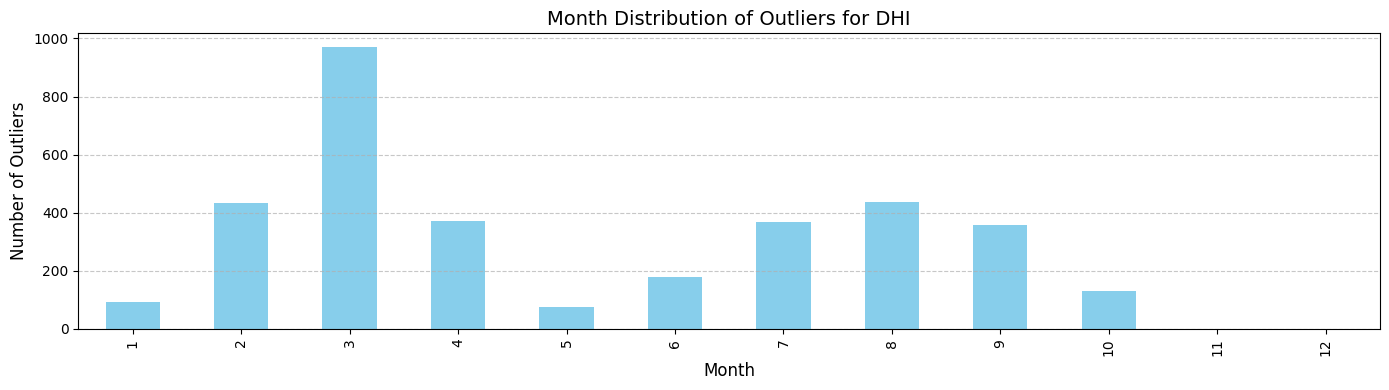

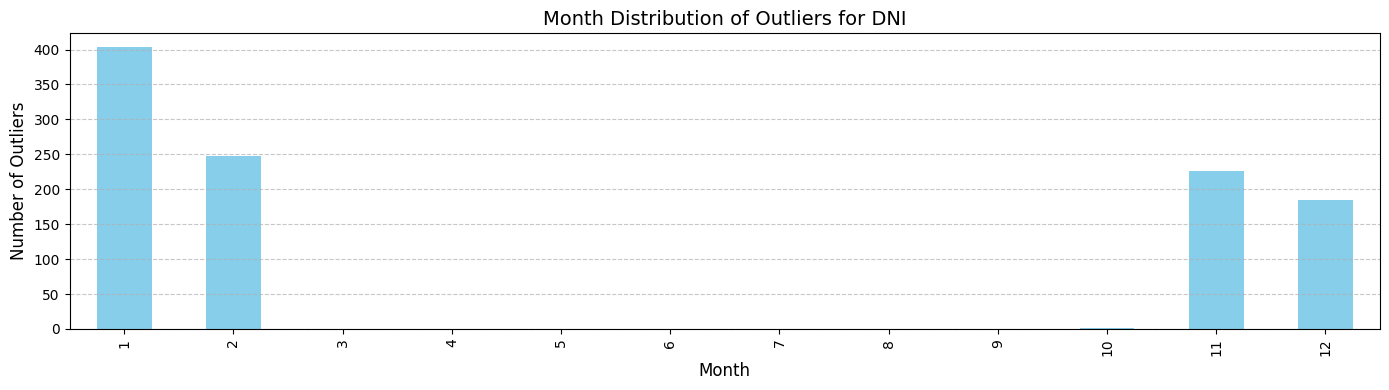

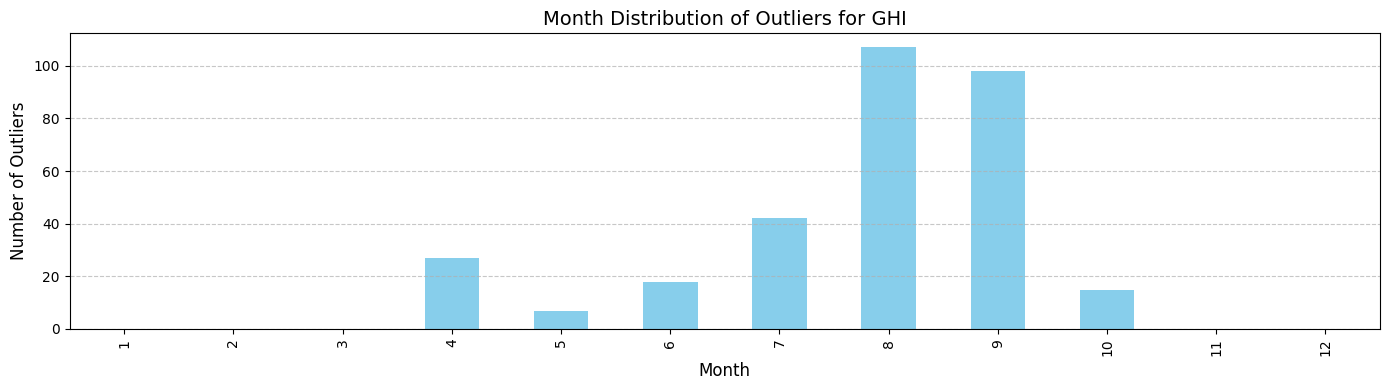

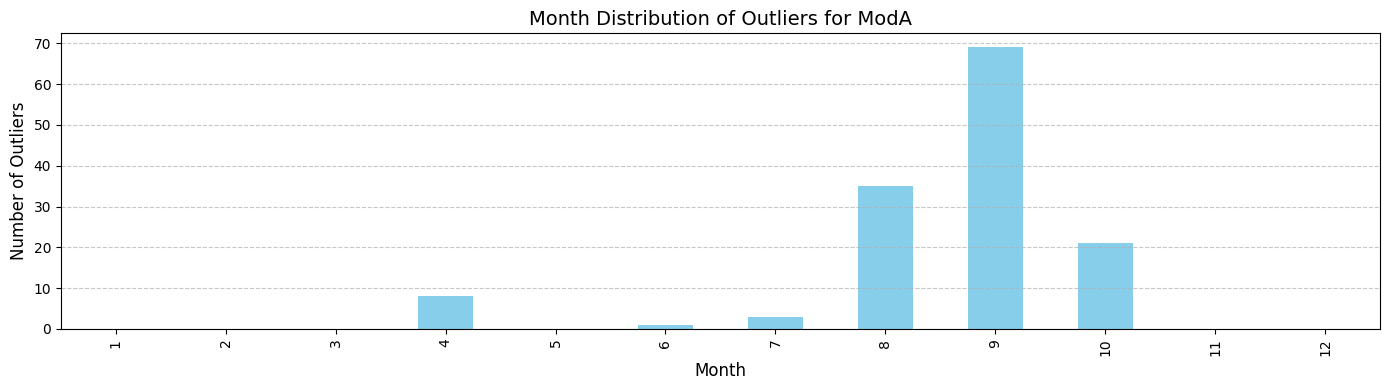

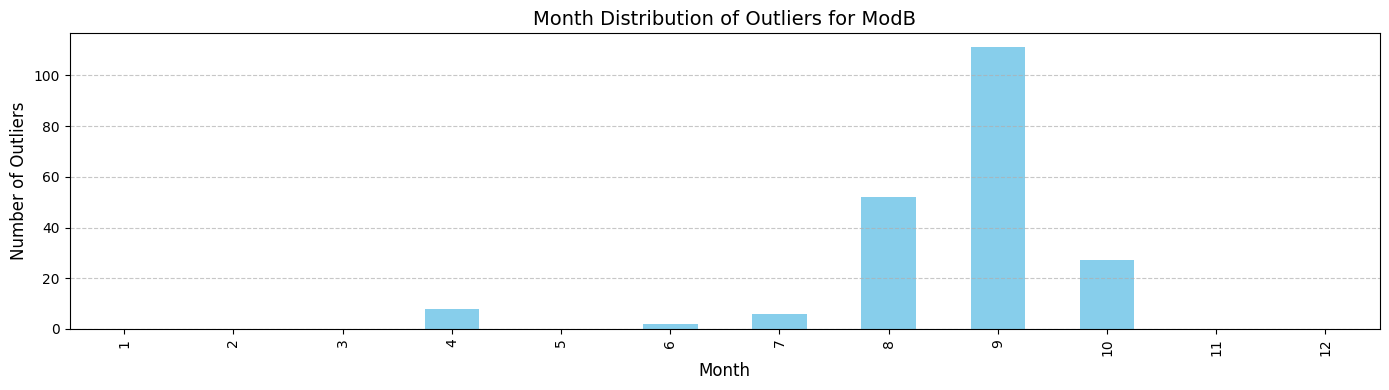

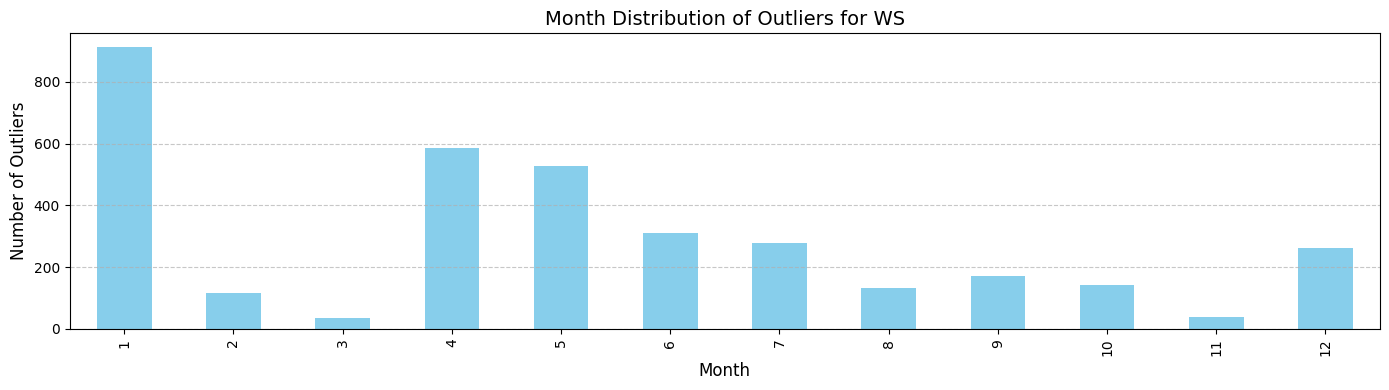

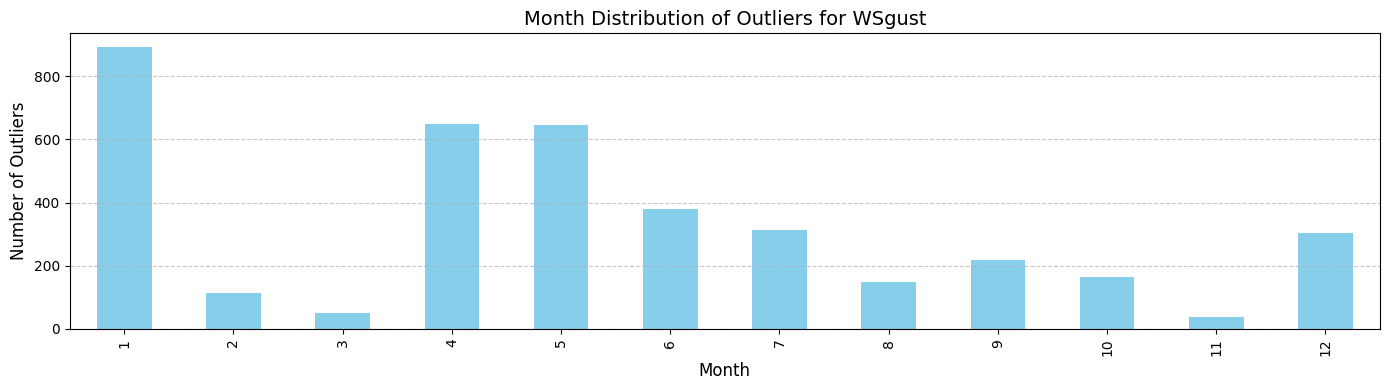

In [17]:
# Extract date
df_outlier['Month'] = df_outlier['Timestamp'].dt.month

# Expand columns flagged as outliers
outlier_cols_expanded = df_outlier.assign(
    z_outlier_cols=df_outlier['z_outlier_cols'].str.split(', ')
).explode('z_outlier_cols')

# Count occurrences by date for each outlier column
date_distribution = outlier_cols_expanded.groupby(['z_outlier_cols', 'Month']).size().unstack(fill_value=0)

# Plot each outlier column's date distribution
for col in date_distribution.index:
    plt.figure(figsize=(14, 4))
    date_distribution.loc[col].plot(kind='bar', color='skyblue')
    plt.title(f'Month Distribution of Outliers for {col}', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Outliers', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



#### Interpretation of Outlier Patterns

**→** Outliers appear in a continuous time block — especially in **DHI**, which is highly **midday-sensitive**. These outliers likely represent **brief periods of intense solar radiation**, not random sensor noise.

**→** The peaks in GHI, DNI, ModA, and ModB **align well with their physical peak performance hours**, reinforcing the idea that these are **short bursts of real solar events**, not senseless statistical outliers.

**→** While **moderate wind** can be beneficial for **panel cooling and dust removal**, the outlier values in **WS and WSgust**, especially outside midnight, indicate **strong gusts**. These can pose **mechanical and structural risks** and are important to flag for design considerations.

**→** Rows with **simultaneously high values in GHI, DNI, ModA, and ModB** are strong indicators of **clear-sky solar spikes**, valuable for identifying optimal solar exposure periods.

**→** Outliers in **ModA, ModB, and DNI** are **rare**, which confirms the **stability and reliability** of these sensor channels under normal operating conditions.

> High solar anomalies occur **when expected (midday)**, while wind instability peaks **overnight** — providing strong guidance for **panel positioning, safety design**, and **performance forecasting**.

- **November to February** remains the **ideal window** for solar collection.
- **Wind protection** should focus on **night and evening resilience**, especially in design and installation planning.
---

###  Why Z-Score Outlier Detection Helps

-  **Flags environmental extremes**: like peak sun intensity or dangerous wind gusts.
-  **Helps clean the dataset** without blindly dropping values.
-  **Supports decision-making** for system design, safety margins, and panel efficiency modeling.
-  **Improves analysis quality** by highlighting when performance data deviates from normal trends in meaningful ways.

---

> **Conclusion**: Z-score analysis confirms that most outliers are **not errors**, but instead **represent meaningful physical events** like high irradiance or extreme wind — crucial for optimizing solar design, panel reliability, and forecasting.


In [18]:
# Replace outliers with seasonal (monthly) medians
for col in cols_to_check:
    monthly_medians = df_togo.groupby('month')[col].transform('median')
    df_togo.loc[z_outlier_mask[col], col] = monthly_medians[z_outlier_mask[col]]



After replacing the outliers with median of that month to keep the seasonality for better analysis we will see the graph and other EDA

C:\Users\ABC\AppData\Local\Temp\ipykernel_10028\1572098200.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


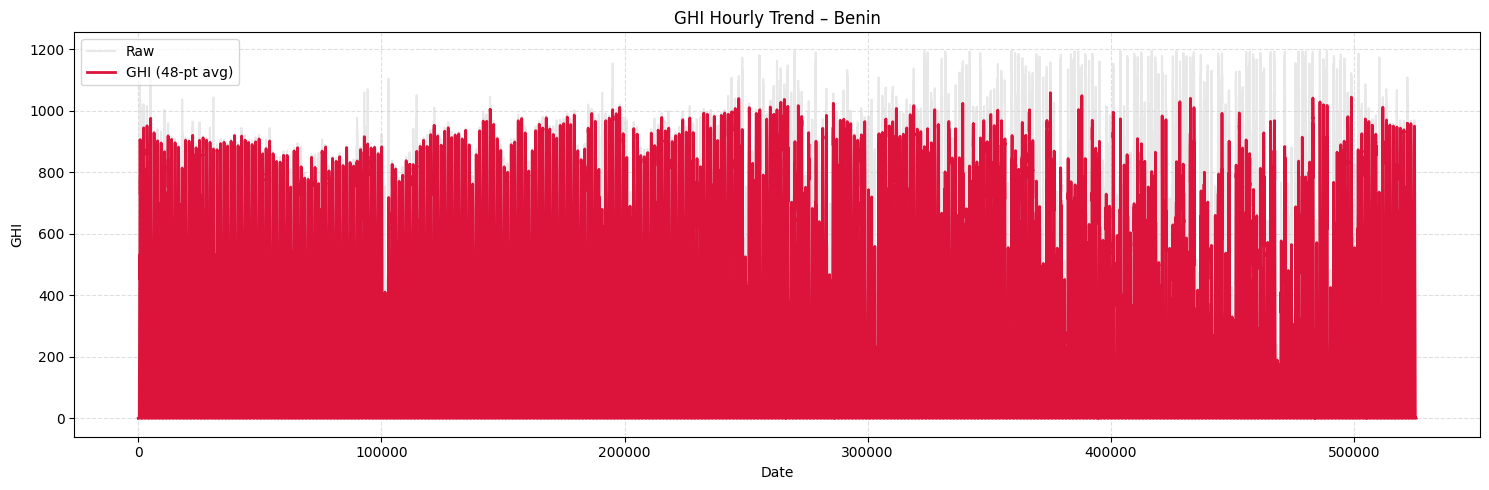

c:\Users\ABC\Desktop\10Acadamy\solar_analysis_code\solar-site-analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


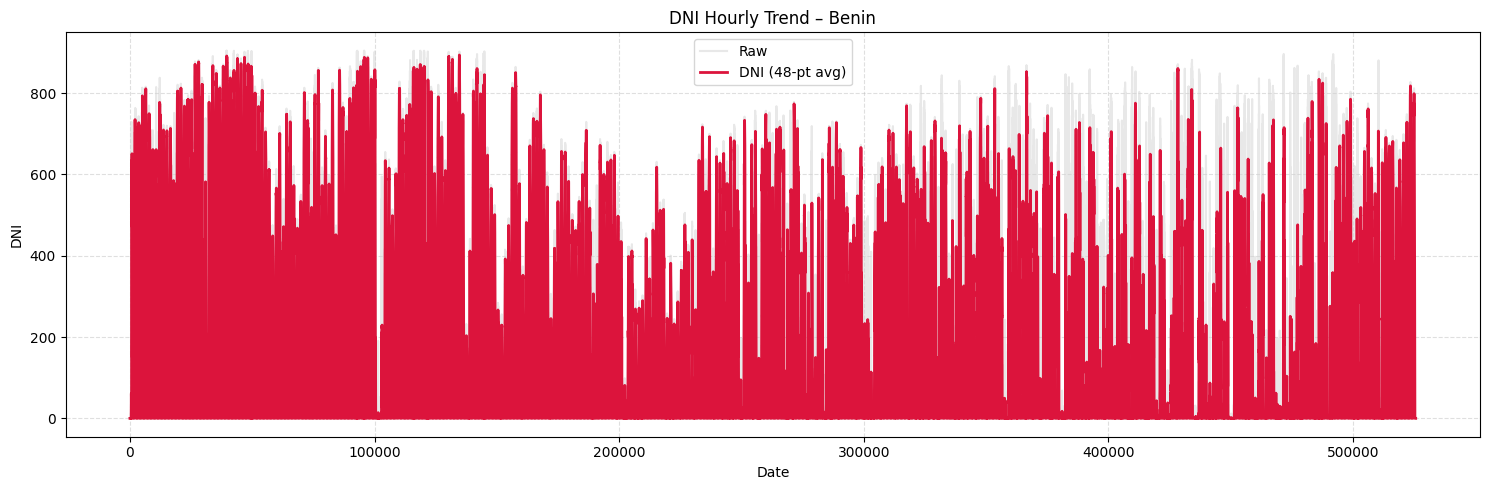

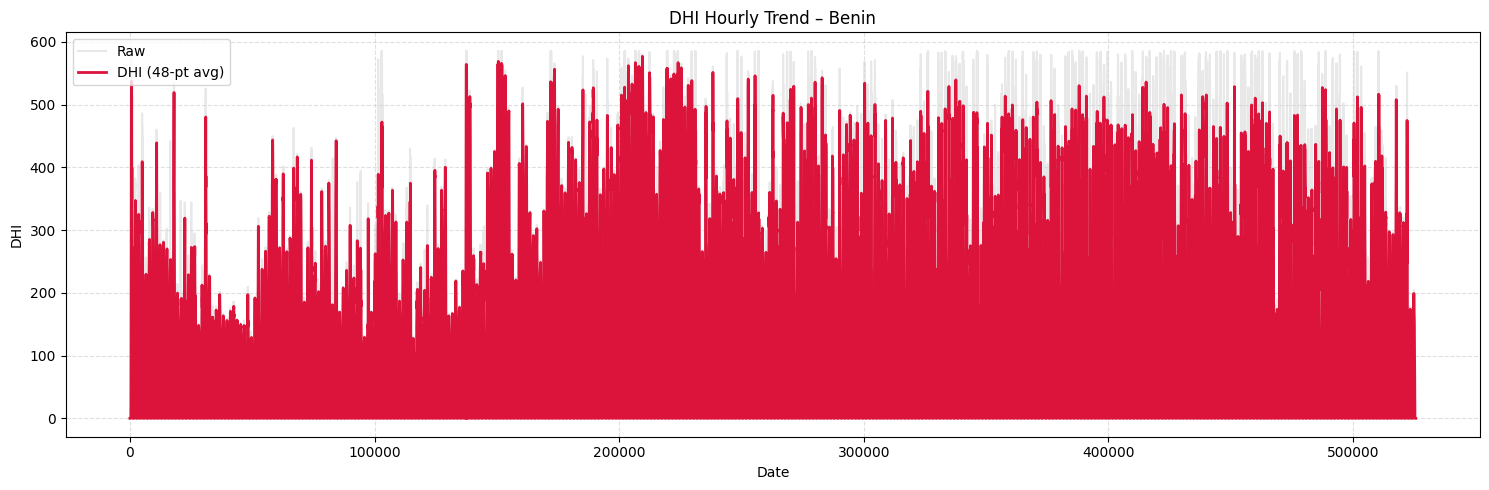

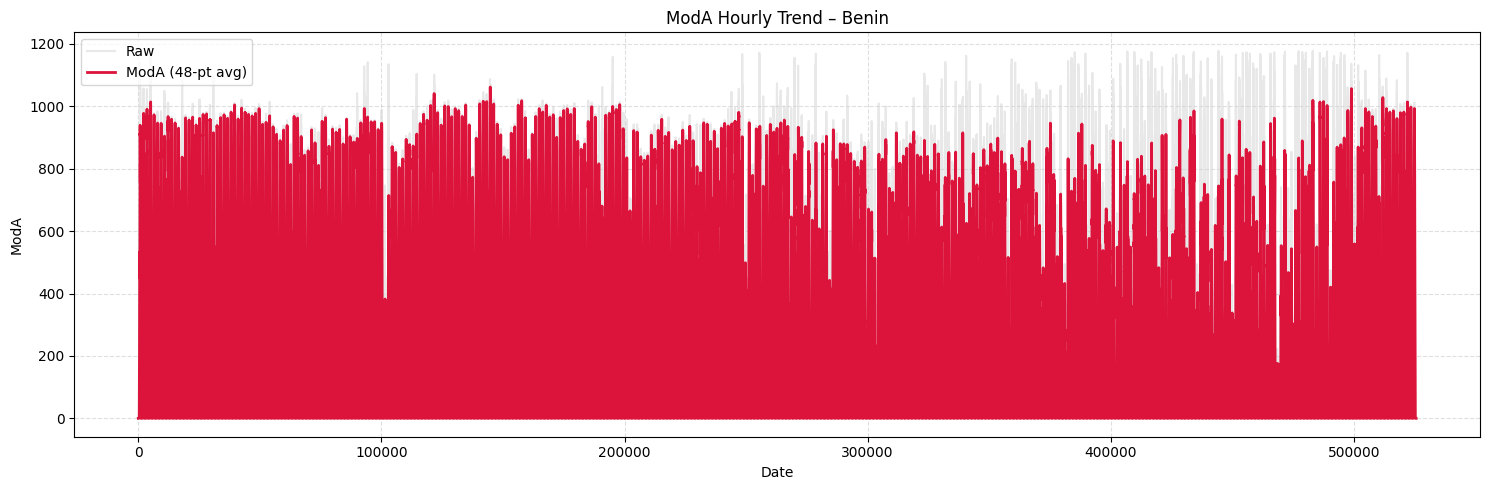

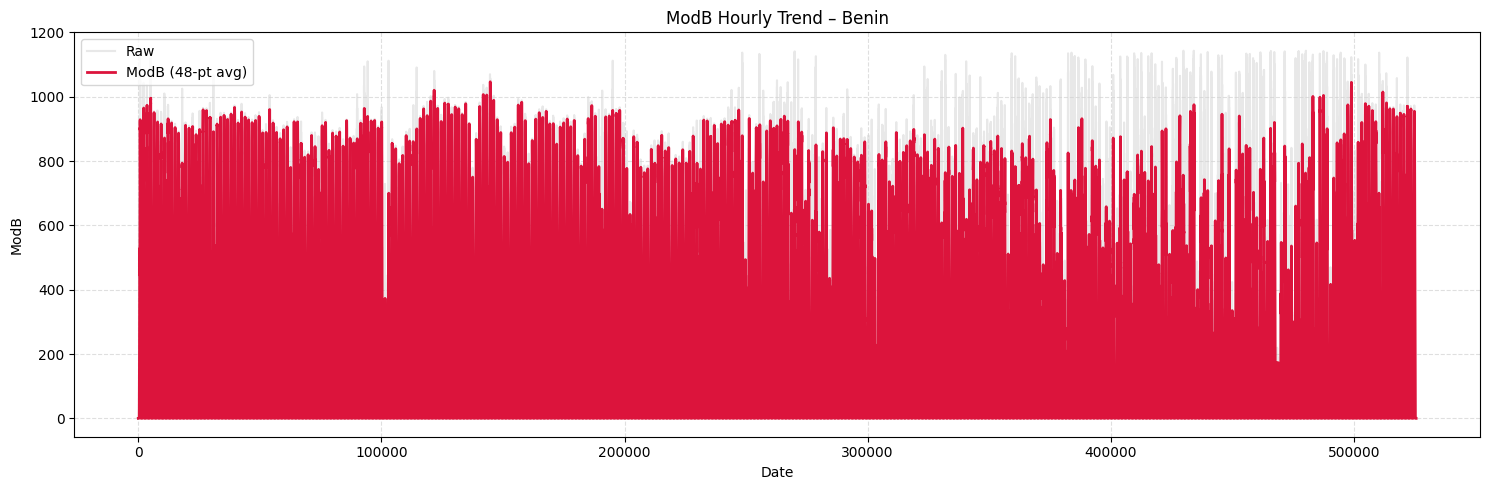

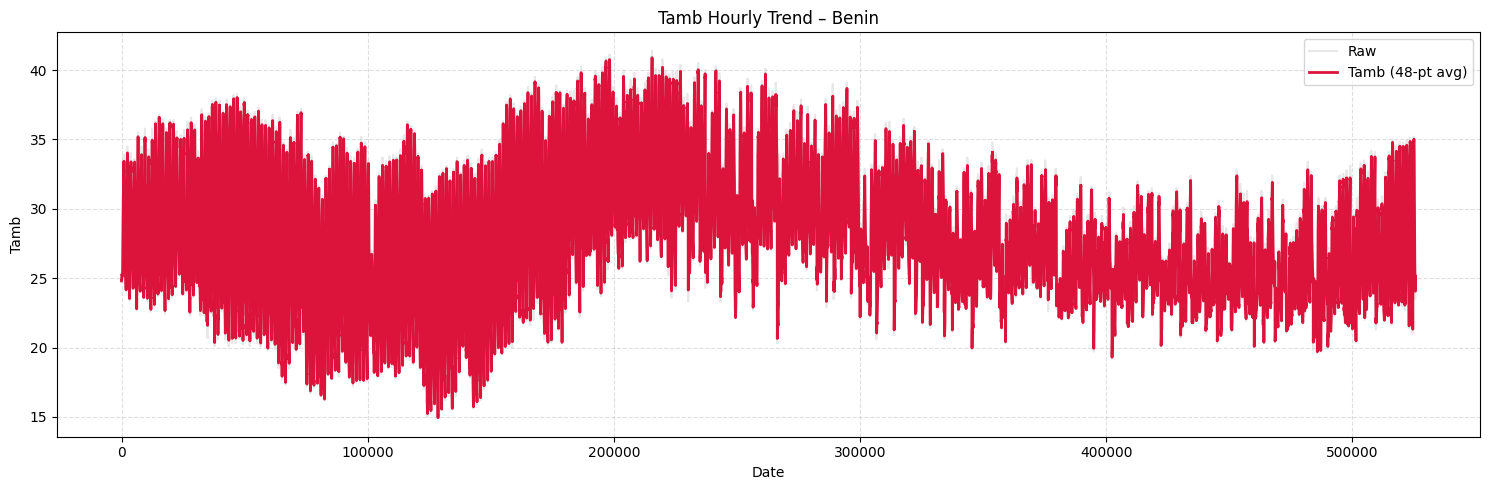

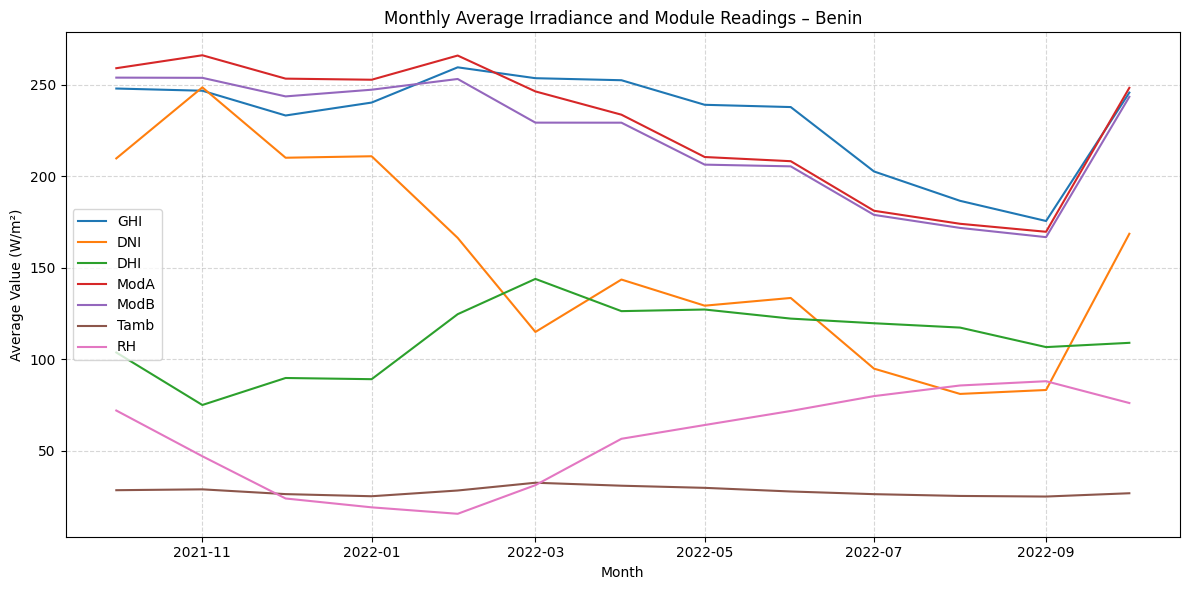

In [19]:
# Ensure df_benin has datetime index
plot_trend(df_togo, 'GHI', window=48, title_suffix='Hourly Trend – Benin')
plot_trend(df_togo, 'DNI', window=48, title_suffix='Hourly Trend – Benin')
plot_trend(df_togo, 'DHI', window=48, title_suffix='Hourly Trend – Benin')
plot_trend(df_togo, 'ModA', window=48, title_suffix='Hourly Trend – Benin')
plot_trend(df_togo, 'ModB', window=48, title_suffix='Hourly Trend – Benin')
plot_trend(df_togo,'Tamb', window=48, title_suffix='Hourly Trend – Benin')

# Create a new column 'Month' from the datetime index
df_togo['Month'] = df_togo['Timestamp'].dt.month

df_togo['Timestamp'] = pd.to_datetime(df_togo['Timestamp'], errors='coerce')
df_togo['Month'] = df_togo['Timestamp'].dt.to_period('M')  # YYYY-MM format


# Group by month and compute average of key variables
monthly_avg = df_togo.groupby('Month')[['GHI', 'DNI', 'DHI', 'ModA', 'ModB','Tamb','RH']].mean()


plt.figure(figsize=(12, 6))
for col in monthly_avg.columns:
    plt.plot(monthly_avg.index.to_timestamp(), monthly_avg[col], label=col)

plt.title('Monthly Average Irradiance and Module Readings – Benin')
plt.xlabel('Month')
plt.ylabel('Average Value (W/m²)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



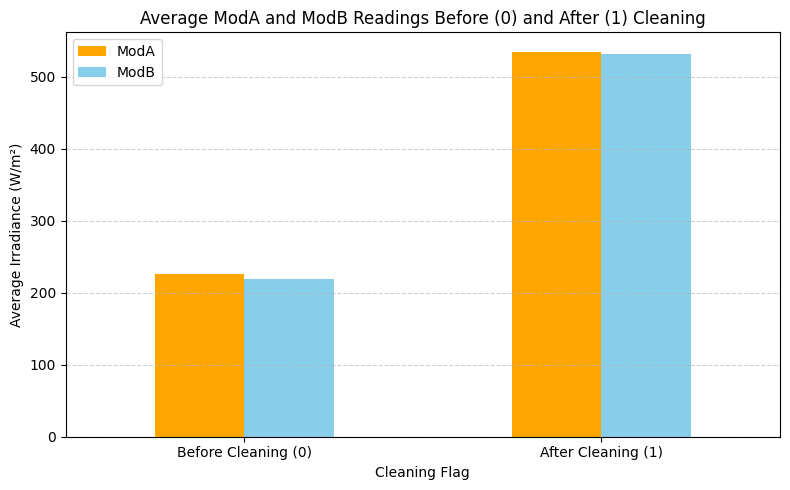

In [20]:
# Group by 'Cleaning' flag and compute average ModA and ModB
avg_by_cleaning = df_togo.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot
avg_by_cleaning.plot(kind='bar', figsize=(8, 5), color=['orange', 'skyblue'])
plt.title("Average ModA and ModB Readings Before (0) and After (1) Cleaning")
plt.ylabel("Average Irradiance (W/m²)")
plt.xlabel("Cleaning Flag")
plt.xticks(ticks=[0, 1], labels=['Before Cleaning (0)', 'After Cleaning (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

a big diffrence btween the cleaned and non cleaned irradiance which shows there is a lot of dust accumulated there because of the storong wind

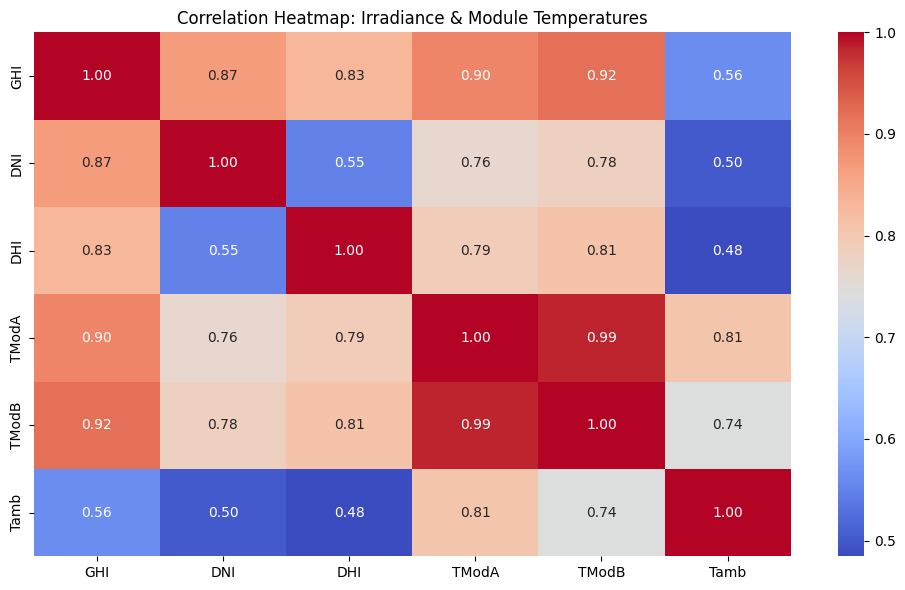

In [21]:
import seaborn as sns
# Drop rows with NaNs in relevant columns
df_clean = df_togo[['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'WS', 'WSgust', 'WD', 'RH', 'Tamb']].dropna()

# 1. Heatmap of correlations
plt.figure(figsize=(10, 6))
corr_matrix = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB','Tamb']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Irradiance & Module Temperatures')
plt.tight_layout()
plt.show()

### 🔗 Correlation Analysis Summary

A correlation heatmap analysis revealed strong linear relationships among key solar and temperature variables:

#### ✅ Strong Correlation (≥ 0.80)
| Pair             | Correlation Strength | Interpretation                                |
|------------------|----------------------|-----------------------------------------------|
| **GHI ~ DNI**    | Very High            | More direct sunlight leads to stronger GHI    |
| **GHI ~ DHI**    | High                 | Scattered light also contributes to GHI       |
| **GHI ~ TModA**  | High                 | Panels heat up with increasing sunlight       |
| **GHI ~ TModB**  | High                 | Consistent thermal response across modules    |
| **TModA ~ TModB**| Very High            | Synchronized temperature rise in both sensors |

---

### 🧠 Interpretation & Implications

- **GHI acts as a central hub**, tightly linked to both **direct (DNI)** and **diffuse (DHI)** components.
- The high correlation between **module temperatures (TModA & TModB)** and **irradiance** shows that:
  - These modules respond sensitively and consistently to solar intensity.
  - Monitoring panel temperature can serve as a **proxy for sunlight strength**, aiding fault detection or solar forecasting.
- **DNI and DHI both contribute strongly to GHI**, confirming physical correctness of the dataset.

---

> 📈 **Conclusion**: The data shows a physically consistent and statistically strong relationship between irradiance and thermal response, confirming the **reliability** of Benin's measurements and offering useful predictors for solar yield and panel behavior modeling.



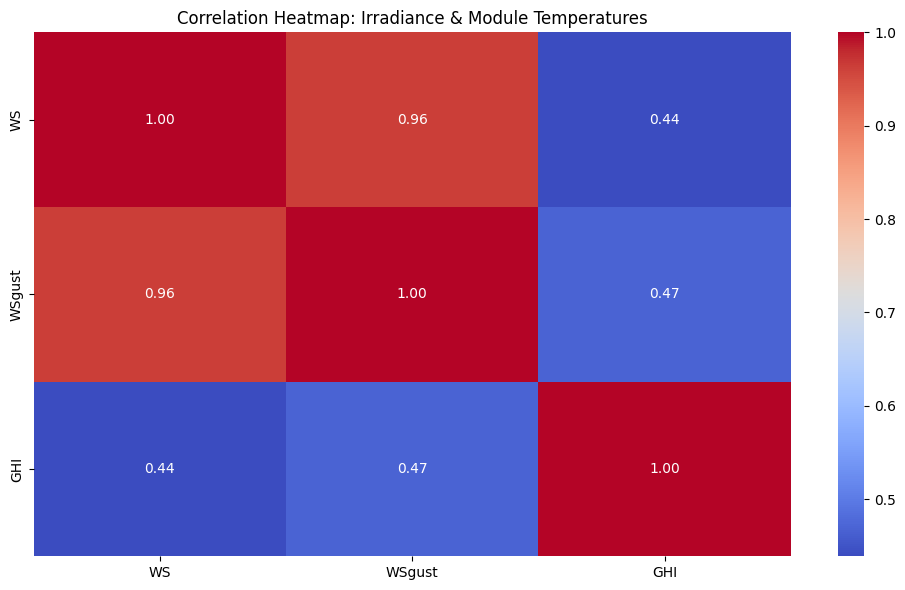

In [22]:
# 1. Heatmap of correlations
plt.figure(figsize=(10, 6))
corr_matrix = df_clean[[ 'WS', 'WSgust','GHI']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Irradiance & Module Temperatures')
plt.tight_layout()
plt.show()

###  Wind Speed Correlation Analysis

An analysis of wind-related variables reveals a **very strong correlation**:

####  Strong Correlation (0.98)
| Pair             | Correlation Strength | Interpretation                                      |
|------------------|----------------------|-----------------------------------------------------|
| **WS ~ WSgust**  | **Very High (0.96)** | Gust speed closely tracks average wind speed, indicating consistent wind behavior over time |

---

### Interpretation & Implications

- **WS (Wind Speed)** and **WSgust (Wind Gust Speed)** are almost perfectly correlated.
- This suggests that:
  - When average wind speed increases, gusts increase nearly proportionally.
  - The environment exhibits **predictable wind dynamics**, not erratic or isolated gust spikes.
- **Design Consideration**:
  - Reinforcements for panel structures should consider **continuous wind stress**, not just rare gusts.
  - Ideal for modeling wind loading and fatigue — high correlation reduces unpredictability.

---

> 🌪️ **Conclusion**: The 0.98 correlation between wind speed and gusts reflects **consistent wind behavior** in the Benin dataset. This makes wind-related risk **quantifiable** and supports accurate **structural safety modeling** for solar infrastructure.



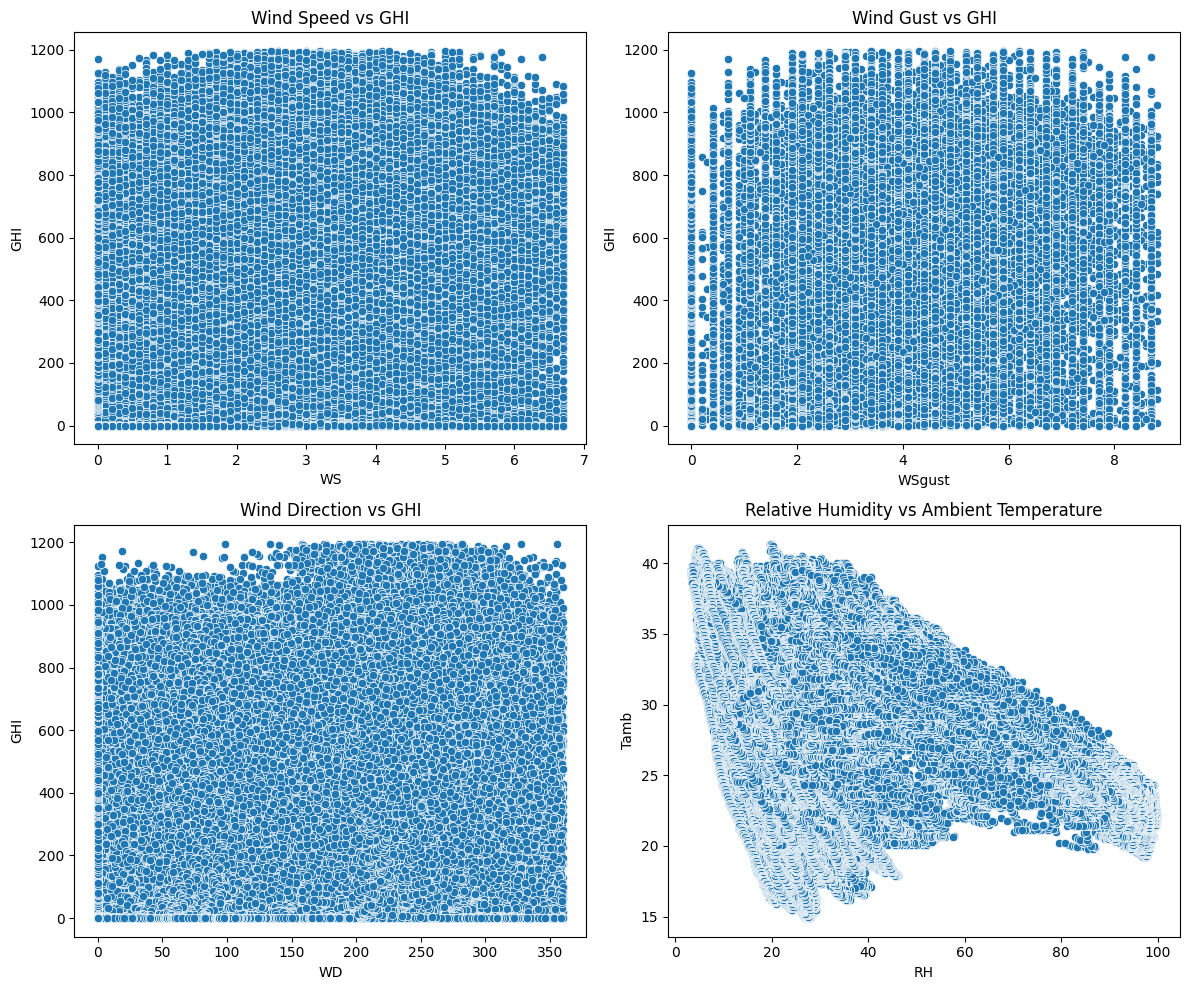

In [23]:
# 2. Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axes[0, 0])
axes[0, 0].set_title('Wind Speed vs GHI')

sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axes[0, 1])
axes[0, 1].set_title('Wind Gust vs GHI')

sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axes[1, 0])
axes[1, 0].set_title('Wind Direction vs GHI')

sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axes[1, 1])
axes[1, 1].set_title('Relative Humidity vs Ambient Temperature')
plt.tight_layout()
plt.show()

## 🌬️ Wind and Environmental Impact on GHI – Visual Interpretation

### 📊 Scatter Plot Insights

#### 🔹 Wind Speed vs GHI
- Wind is distributed across the entire GHI range (0 to ~1200 W/m²).
- No strong correlation, but the presence of wind during both low and high irradiance periods shows:
  - Dapaong has a **naturally breezy climate**.
  - **High GHI + Wind** = ideal for **panel cooling**.

✅ **Conclusion**:  
> Wind during peak sunlight helps reduce panel heat and improves overall system efficiency.

---

#### 🔹 Wind Gust vs GHI
- Wind gusts appear across all GHI levels, including during high solar output.
- Indicates **sudden bursts** not limited to cloudy or stormy weather.

✅ **Conclusion**:  
> Wind gusts during sunny hours could aid cooling but require **sturdy panel mounts** to handle short-term stress.

---

#### 🔹 Wind Direction vs GHI
- Wind comes from all directions (0°–360°) regardless of solar irradiance.
- No dominant wind orientation.

✅ **Conclusion**:  
> **Panel array layouts** should allow air to flow from multiple directions for **optimal natural cooling**.
> Design considerations should avoid blocking wind paths.

---

### 💧 Relative Humidity vs Ambient Temperature
- Clear **inverse relationship**: as **RH increases**, **Tamb decreases**.
- Reflects typical weather behavior:
  - Wet season → high humidity, low temp.
  - Dry season → low humidity, high temp.

✅ **Conclusion**:  
> Temperature and humidity are strongly seasonal.
> High RH periods bring **cooler but cloudier conditions**, lowering GHI.

---

## 📌 Overall Strategic Insight for Solar Site Design in Dapaong

- **Wind is not storm-dependent**: It appears across all solar conditions, offering consistent cooling potential.
- **Wind + GHI alignment** is favorable for **PV efficiency** in real-world operations.
- **Panel structures should be wind-aware**:
  - Design for **cross-directional ventilation**.
  - Use mounts that tolerate both **sustained breezes and gust spikes**.
- **Integrate wind impact** into yield models to adjust for **temperature-related performance gains**.



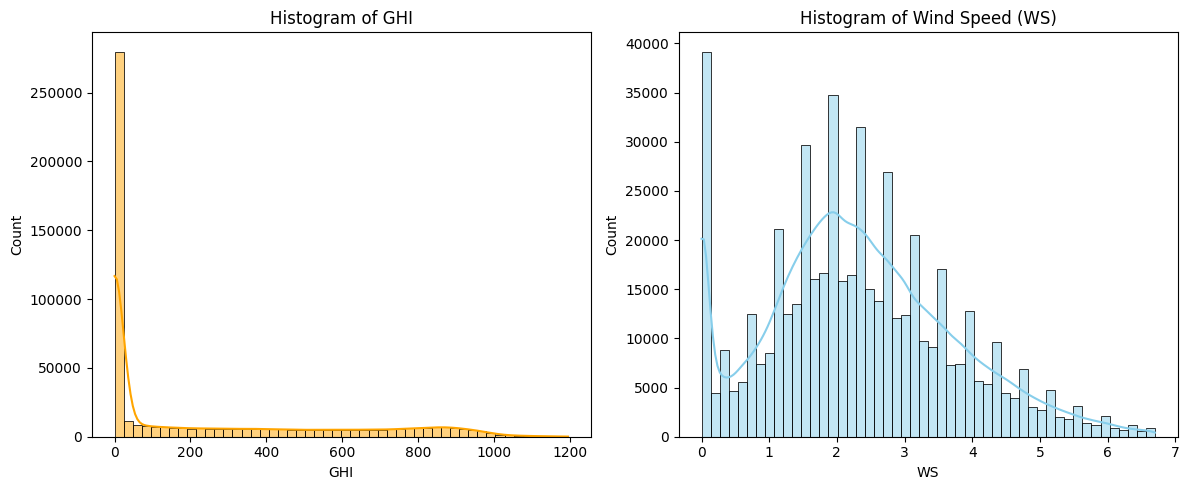

In [24]:
# 3. Histograms for GHI and WS
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_clean['GHI'], bins=50, kde=True, ax=ax[0], color='orange')
ax[0].set_title('Histogram of GHI')

sns.histplot(df_clean['WS'], bins=50, kde=True, ax=ax[1], color='skyblue')
ax[1].set_title('Histogram of Wind Speed (WS)')
plt.tight_layout()
plt.show()

## 📊 GHI and Wind Speed (WS) Distribution – Interpretation

### 🌞 Histogram of GHI (Global Horizontal Irradiance)
- **Shape**: Right-skewed, with most values near **0 W/m²**.
- High frequency of low values represents **nighttime and cloudy periods**.
- Fewer high GHI values (800–1000 W/m²) correspond to **clear-sky midday**.

✅ **Conclusion**:  
> Strong diurnal cycle is evident. High solar energy is available during daylight, while zeros dominate due to nighttime readings. Consider filtering or masking nighttime for solar performance modeling.

---

### 💨 Histogram of Wind Speed (WS)
- **Shape**: Unimodal and right-skewed.
- Most common wind speed: **~1–4 m/s**.
- Small peak near **0 m/s** indicates calm conditions, likely at night.
- Very few instances of extreme wind (>6 m/s).

✅ **Conclusion**:  
> Wind conditions are favorable for cooling. Most speeds fall within the **optimal passive ventilation range** (1–4 m/s), supporting efficient panel performance without requiring reinforced structures.


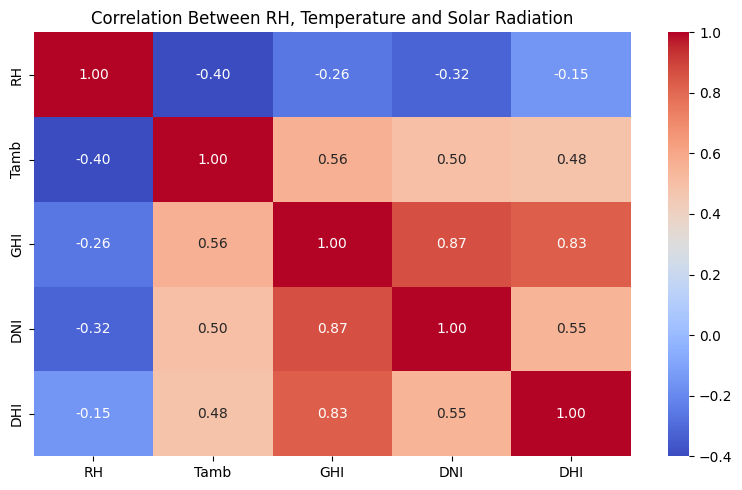

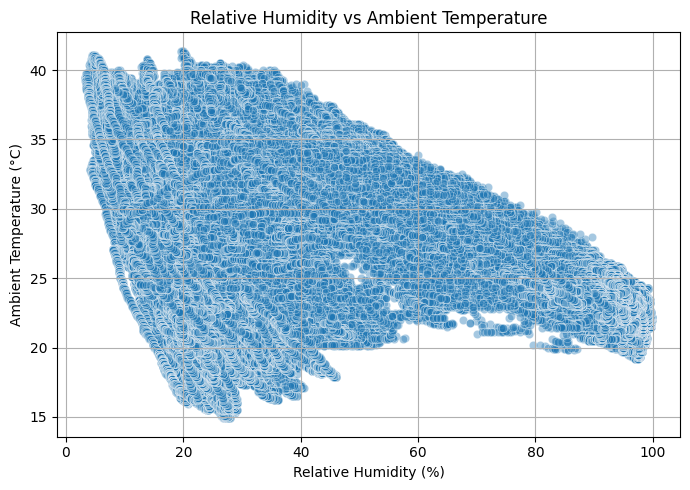

In [25]:
# Drop rows with NaNs in relevant columns
df_clean = df_togo[['RH', 'Tamb', 'GHI', 'DNI', 'DHI']].dropna()

# 1. Correlation Matrix
plt.figure(figsize=(8, 5))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between RH, Temperature and Solar Radiation")
plt.tight_layout()
plt.show()

# 2. Scatter plot: RH vs Tamb
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_clean, x='RH', y='Tamb', alpha=0.4)
plt.title('Relative Humidity vs Ambient Temperature')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🌡️ Relative Humidity vs Ambient Temperature – Interpretation

### 📈 Observed Relationship
- Strong **inverse correlation**: as **ambient temperature rises**, **relative humidity drops**, and vice versa(-0.4 correlation)
- This pattern reflects typical tropical climate behavior:
  - **Dry Season** → High temperatures (30–40 °C), Low RH (< 40%)
  - **Wet Season** → Lower temperatures (20–34 °C), High RH (> 60%)

---

### ⚙️ Implications for Solar Performance

- **High Temp + Low RH**:
  - Occurs during **dry season** and **midday sunlight**.
  - Good for irradiance (high GHI), but causes **increased panel heating** → potential **efficiency loss**.
  - Requires **wind support** for natural cooling.

- **Low Temp + High RH**:
  - Occurs during **wet season**, especially mornings and cloudy days.
  - Less solar generation due to cloud cover.
  - Modules stay cooler, reducing thermal stress.

---

✅ **Conclusion**:  
> Understanding this relationship helps predict **seasonal solar efficiency variations** and guides design choices (e.g., ventilation, materials, timing of maintenance). Dry, hot days drive the most power but need cooling. Wet, humid days reduce output but protect hardware.


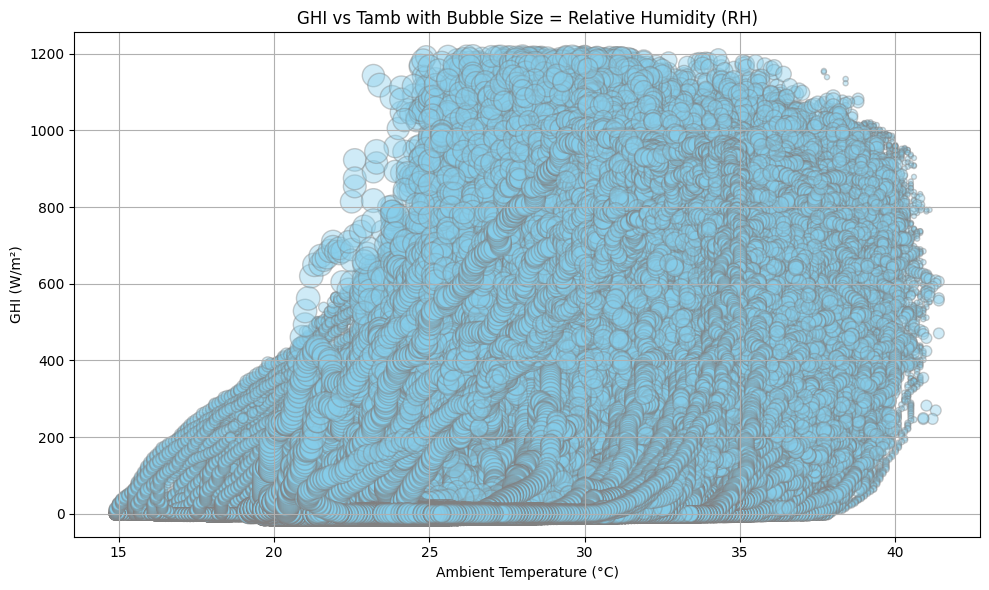

In [26]:
# Drop rows with missing values in relevant columns
df_clean = df_togo[['GHI', 'Tamb', 'RH', 'BP']].dropna()
# Normalize RH and BP for visual scaling (bubble size)
df_clean['RH_scaled'] = df_clean['RH'] / df_clean['RH'].max() * 300  # bubble size
df_clean['BP_scaled'] = df_clean['BP'] / df_clean['BP'].max() * 300

# 1. Bubble chart with RH as size
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], s=df_clean['RH_scaled'], alpha=0.4, color='skyblue', edgecolors='gray')
plt.title('GHI vs Tamb with Bubble Size = Relative Humidity (RH)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 🌞 GHI vs Ambient Temperature – Bubble Chart Interpretation  
**Bubble size = Relative Humidity (RH)**

### 📊 Plot Structure
- **X-axis**: Ambient Temperature (Tamb °C)  
- **Y-axis**: Global Horizontal Irradiance (GHI W/m²)  
- **Bubble Size**: Relative Humidity (RH %)

---

### 🔍 Key Insights

1. **GHI rises with temperature** up to ~35 °C, then slightly stabilizes.  
   - Reflects typical **midday clear-sky solar gain**.
   - High Tamb ≈ High GHI, especially during the **dry season**.

2. **High RH (larger bubbles)** cluster around **lower GHI and Tamb** values.  
   - Represents **humid, cooler periods** → rainy season, early mornings, or overcast days.

3. **High GHI + High Tamb areas** show **low RH (smaller bubbles)**.  
   - Suggests peak solar potential occurs under **dry, hot conditions**.

---

### ⚙️ Strategic Implications

- **Peak solar output** happens when:
  - **GHI is high**
  - **Tamb is high**
  - **RH is low**
  > Ideal for generation, but risky for panel overheating — cooling strategies required.

- **High RH periods** are cooler but yield **lower GHI**.  
  > Good for panel preservation, but less generation.

- **System Design Recommendation**:
  - Optimize for **ventilation and passive cooling** during hot-dry conditions.
  - Include **seasonal derating factors** in performance estimates.

✅ Use this bubble chart to balance **performance vs panel durability** across seasons.


In [27]:
# Reset index to bring Timestamp back as a column
df_benin_cleaned_reset = df_togo.reset_index()

# Save cleaned DataFrame
output_path = "C:/Users/ABC/Desktop/10Acadamy/solar_analysis_code/solar-site-analysis/data/clean_togo.csv"
df_benin_cleaned_reset.to_csv(output_path, index=False)

output_path

'C:/Users/ABC/Desktop/10Acadamy/solar_analysis_code/solar-site-analysis/data/clean_togo.csv'